## headerを確認する

In [3]:
import numpy as np
import pandas as pd

# データファイルを読み込み
data_path = '/Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/train/train.csv'
train_data = pd.read_csv(data_path, low_memory=False)

print(train_data.head())

   Age  Gender     T_Bil     D_Bil         ALP    ALT_GPT     AST_GOT  \
0   59    Male  0.786886  0.150498  220.178691  13.467617   21.729246   
1   69    Male  1.003987  0.195625  221.218413  51.033462   64.752323   
2   65    Male  0.657140  0.081287  320.770533  12.625011   30.613180   
3   65    Male  0.906822  0.214173  369.278160  34.347597   54.510085   
4   22  Female  1.734959  0.197706  222.782025  20.572891  170.010177   

         TP       Alb  AG_ratio  disease  
0  6.815731  3.112276  1.006802        0  
1  6.889608  3.051521  0.751346        1  
2  5.947767  2.489167  0.774952        0  
3  6.967183  3.613837  0.988155        1  
4  5.837537  3.068697  1.026654        0  


### 特徴量の分布を確認して対数変換を適用する

In [4]:
import numpy as np
import pandas as pd

# データファイルを読み込み
data_path = '/Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/train/train.csv'
train_data = pd.read_csv(data_path, low_memory=False)

# 対数変換を適用
train_data['T_Bil_log'] = np.log1p(train_data['T_Bil'])
train_data['D_Bil_log'] = np.log1p(train_data['D_Bil'])
train_data['ALP_log'] = np.log1p(train_data['ALP'])
train_data['ALT_GPT_log'] = np.log1p(train_data['ALT_GPT'])
train_data['AST_GOT_log'] = np.log1p(train_data['AST_GOT'])

# TPに対してnp.log()を適用（0以下の値がないことが確認されている場合）
train_data['TP_log'] = np.log(train_data['TP'])
train_data['Alb_log'] = np.log(train_data['Alb'])
train_data['AG_ratio_log'] = np.log(train_data['AG_ratio'])

# データをファイルに保存
save_path = '/Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/train/train_log.csv'
train_data.to_csv(save_path, index=False)
print(f"ログ変換後のデータが {save_path} に保存されました。")

ログ変換後のデータが /Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/train/train_log.csv に保存されました。


## 異常値を検出してクリッピングを行う(必要な場合）
すべての特徴量に対数変換を適用した結果、今回はクリッピングを行いません。

AG_ratioのIQR: 0.30000000000000004
異常値の下限: 0.35, 上限: 1.5500000000000003
AG_ratioの外れ値の数（クリッピング前）: 192
AG_ratioの外れ値の数（クリッピング後）: 13077


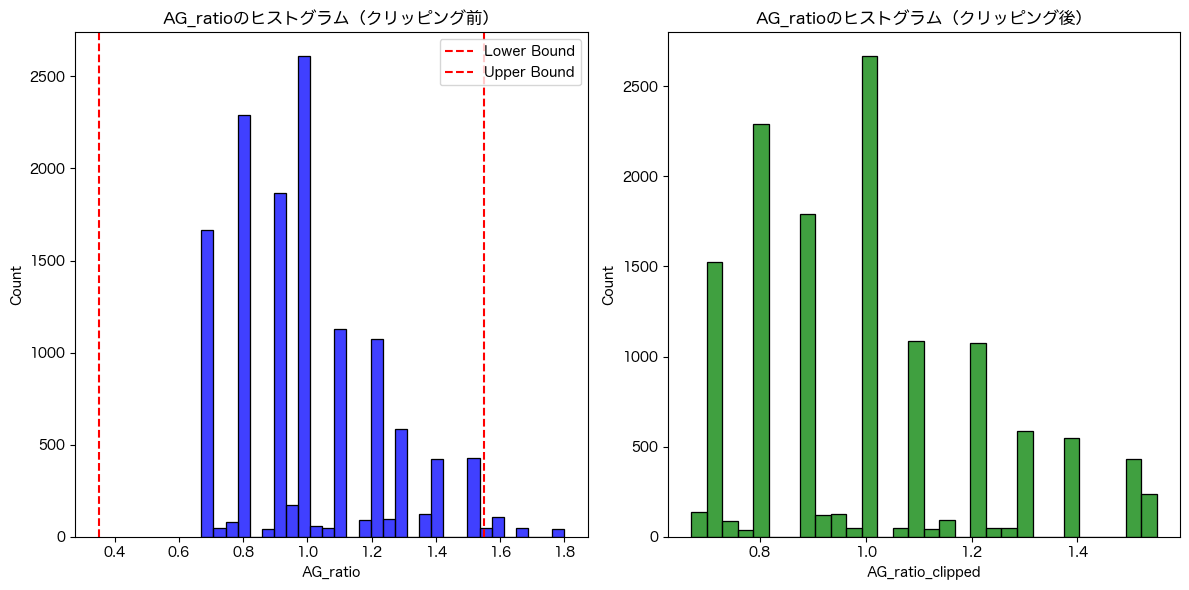

クリッピング後のデータが /Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/train/AG_ratio_clipped.csv に保存されました。


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 日本語フォントの設定
plt.rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro']  # Mac用
plt.rcParams['axes.unicode_minus'] = False

# データファイルを読み込み
data_path = '/Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/train/train.csv'
train_data = pd.read_csv(data_path, low_memory=False)

# AG_ratio列の四分位数を計算
Q1 = train_data['T_Bil'].quantile(0.25)  # 第1四分位数 (25%)
Q3 = train_data['T_Bil'].quantile(0.75)  # 第3四分位数 (75%)
IQR = Q3 - Q1  # 四分位範囲 (IQR)

# 1.5倍IQRを使って異常値の範囲を計算
lower_bound = Q1 - 1.5 * IQR  # 下限
upper_bound = Q3 + 1.5 * IQR  # 上限

print(f"AG_ratioのIQR: {IQR}")
print(f"異常値の下限: {lower_bound}, 上限: {upper_bound}")

# 外れ値の行数を表示（クリッピング前）
outliers = (train_data['AG_ratio'] < lower_bound) | (train_data['AG_ratio'] > upper_bound)
print(f"AG_ratioの外れ値の数（クリッピング前）: {outliers.sum()}")

# AG_ratio列をクリッピング
train_data['AG_ratio_clipped'] = train_data['AG_ratio'].clip(lower=lower_bound, upper=upper_bound)

# クリッピング後の外れ値の数を確認（クリッピング後は外れ値がないはず）
outliers_after_clipping = (train_data['AG_ratio_clipped'] < lower_bound) | (train_data['Alb_clipped'] > upper_bound)
print(f"AG_ratioの外れ値の数（クリッピング後）: {outliers_after_clipping.sum()}")

# クリッピングする前のヒストグラム
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(train_data['AG_ratio'], kde=False, bins=30, color='blue')
plt.axvline(lower_bound, color='red', linestyle='--', label='Lower Bound')
plt.axvline(upper_bound, color='red', linestyle='--', label='Upper Bound')
plt.title('AG_ratioのヒストグラム（クリッピング前）')
plt.legend()

# クリッピングした後のヒストグラム
plt.subplot(1, 2, 2)
sns.histplot(train_data['AG_ratio_clipped'], kde=False, bins=30, color='green')
plt.title('AG_ratioのヒストグラム（クリッピング後）')

plt.tight_layout()
plt.show()

# クリッピング後のデータをファイルに保存
save_path = '/Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/train/AG_ratio_clipped.csv'
train_data.to_csv(save_path, index=False)
print(f"クリッピング後のデータが {save_path} に保存されました。")


# headerを確認する

In [5]:
import numpy as np
import pandas as pd

# データファイルを読み込み
data_path = '/Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/train/train_log.csv'
train_data = pd.read_csv(data_path, low_memory=False)

train_data.head()

,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease,T_Bil_log,D_Bil_log,ALP_log,ALT_GPT_log,AST_GOT_log,TP_log,Alb_log,AG_ratio_log
0,59,Male,0.786886,0.150498,220.178691,13.467617,21.729246,6.815731,3.112276,1.006802,0,0.580474,0.140195,5.398971,2.671913,3.123652,1.919233,1.135354,0.006779
1,69,Male,1.003987,0.195625,221.218413,51.033462,64.752323,6.889608,3.051521,0.751346,1,0.695139,0.178669,5.403661,3.951887,4.185895,1.930014,1.115640,-0.285889
2,65,Male,0.657140,0.081287,320.770533,12.625011,30.613180,5.947767,2.489167,0.774952,0,0.505093,0.078152,5.773839,2.611907,3.453574,1.783016,0.911948,-0.254955
3,65,Male,0.906822,0.214173,369.278160,34.347597,54.510085,6.967183,3.613837,0.988155,1,0.645438,0.194063,5.914255,3.565230,4.016565,1.941211,1.284770,-0.011916
4,22,Female,1.734959,0.197706,222.782025,20.572891,170.010177,5.837537,3.068697,1.026654,0,1.006116,0.180408,5.410672,3.071437,5.141723,1.764309,1.121253,0.026305


## 対数変換前の特徴量を削除する

In [6]:
import pandas as pd

# トレインデータの読み込み
data_path = '/Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/train/train_log.csv'
train_data = pd.read_csv(data_path, low_memory=False)

# 目的変数 'disease' を最後の列に移動
# 'disease' 列を取得
disease_column = train_data['disease']

# '不要な列を削除して他の特徴量を残す
train_data = train_data.drop(columns=['disease', 'T_Bil', 'D_Bil', 'ALP', 'ALT_GPT', 'AST_GOT',
                                      'TP', 'Alb', 'AG_ratio'])
# 'disease' 列を最後に追加
train_data['disease'] = disease_column

# 新しいデータセットの保存
save_path = '/Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/train/train_drop_original.csv'
train_data.to_csv(save_path, index=False)

print(train_data.dtypes)
print(f"データが {save_path} に保存されました。")

Age               int64
Gender           object
T_Bil_log       float64
D_Bil_log       float64
ALP_log         float64
ALT_GPT_log     float64
AST_GOT_log     float64
TP_log          float64
Alb_log         float64
AG_ratio_log    float64
disease           int64
dtype: object
データが /Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/train/train_drop_original.csv に保存されました。


# 相関行列を確認する

Top Correlation Pairs:
D_Bil_log     T_Bil_log      0.844566
Alb_log       TP_log         0.733882
AST_GOT_log   ALT_GPT_log    0.695315
AG_ratio_log  Alb_log        0.608264
disease       AST_GOT_log    0.499429
              T_Bil_log      0.468236
              ALT_GPT_log    0.435482
AST_GOT_log   T_Bil_log      0.432004
disease       D_Bil_log      0.417775
AST_GOT_log   D_Bil_log      0.408443
dtype: float64


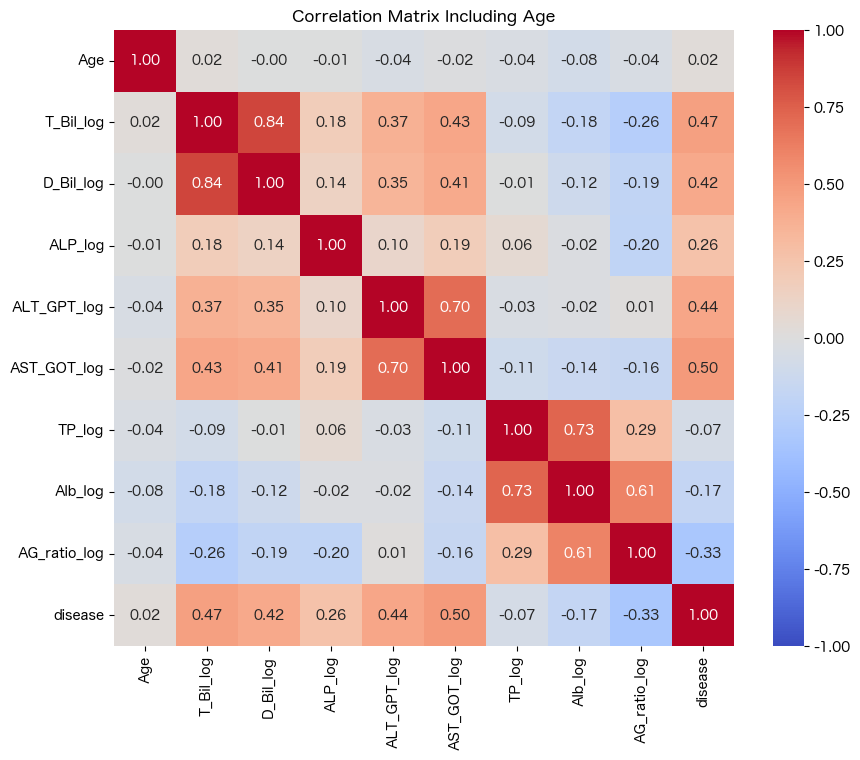

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 日本語フォントの設定
plt.rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro']  # Mac用
plt.rcParams['axes.unicode_minus'] = False

# データファイルを読み込み
data_path = '/Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/train/train_drop_original.csv'
train_data = pd.read_csv(data_path, low_memory=False)

# 数値変数のリスト
numeric_columns = [ 
    'Age', 'T_Bil_log', 'D_Bil_log', 'ALP_log', 'ALT_GPT_log', 'AST_GOT_log', 
    'TP_log', 'Alb_log', 'AG_ratio_log', 'disease'
]

# 数値変数間の相関行列を作成
corr_matrix = train_data[numeric_columns].corr().abs()

# 相関行列を上三角行列に変換して一意のペアを取得
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# 相関が高いペアを取得してソート
sorted_pairs = upper_triangle.unstack().sort_values(ascending=False).dropna()

# 上位30の相関ペアを表示
top_pairs = sorted_pairs.head(10)
print("Top Correlation Pairs:")
print(top_pairs)

# 相関が強い上位の特徴量をヒートマップで可視化
top_features = pd.Index(top_pairs.index.get_level_values(0).append(top_pairs.index.get_level_values(1))).unique()
top_corr_matrix = train_data[top_features].corr()
# 全ての数値変数の相関行列を表示
plt.figure(figsize=(10, 8))
sns.heatmap(train_data[numeric_columns].corr(), annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Matrix Including Age')
plt.show()


In [8]:
# トレインデータの読み込み
data_path = '/Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/train/train_drop_original.csv'
train_data = pd.read_csv(data_path, low_memory=False)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Age           850 non-null    int64  
 1   Gender        850 non-null    object 
 2   T_Bil_log     850 non-null    float64
 3   D_Bil_log     850 non-null    float64
 4   ALP_log       850 non-null    float64
 5   ALT_GPT_log   850 non-null    float64
 6   AST_GOT_log   850 non-null    float64
 7   TP_log        850 non-null    float64
 8   Alb_log       850 non-null    float64
 9   AG_ratio_log  850 non-null    float64
 10  disease       850 non-null    int64  
dtypes: float64(8), int64(2), object(1)
memory usage: 73.2+ KB


### 新しい特徴量を作成する

In [24]:
import numpy as np
import pandas as pd
import os

# データファイルを読み込み
data_path = '/Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/train/train_drop_original.csv'
train_data = pd.read_csv(data_path, low_memory=False)

# 年齢をカテゴリに分ける
# train_data['Age_bucket'] = pd.cut(train_data['Age'], bins=[0, 20, 40, 60, 80, 100], labels=[1, 2, 3, 4, 5])

# 新しい特徴量を作成する
# グロブリンを計算
# train_data['Globulin'] = train_data['TP_log'] - train_data['Alb_log']

# 仮定的な肝機能スコア
# train_data['Liver_Function_Combined_Score'] = (
    # train_data['AST_GOT_log'] + 
    # train_data['T_Bil_log'] - 
    # train_data['Alb_log']
# )

# TP_logとAlb_logの積を新しい特徴量として作成
# train_data['TP_Alb_interaction'] = train_data['TP_log'] * train_data['Alb_log']

# 比を作成する場合
train_data['TP_Alb_ratio'] = train_data['TP_log'] / (train_data['Alb_log'] + 1e-8)  # 0除算を避けるために微小値を加える

from sklearn.decomposition import PCA

# PCAで2つの特徴量を1つの主成分に圧縮
# pca = PCA(n_components=1)
# train_data['TP_Alb_PCA'] = pca.fit_transform(train_data[['TP_log', 'Alb_log']])


# ディレクトリが存在するか確認し、存在しない場合は作成
save_dir = '/Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/train'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# データを保存
train_data_path = os.path.join(save_dir, 'train_with_TP_Alb_ratio.csv')
train_data.to_csv(train_data_path, index=False)
print(f"新しい特徴量を作成しデータを保存しました: {train_data_path}")


新しい特徴量を作成しデータを保存しました: /Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/train/train_with_TP_Alb_ratio.csv


### 相関関係を確認する

Top Correlation Pairs:
D_Bil_log     T_Bil_log       0.844566
AST_GOT_log   ALT_GPT_log     0.695315
TP_Alb_ratio  AG_ratio_log    0.632703
disease       AST_GOT_log     0.499429
              T_Bil_log       0.468236
              ALT_GPT_log     0.435482
AST_GOT_log   T_Bil_log       0.432004
disease       D_Bil_log       0.417775
AST_GOT_log   D_Bil_log       0.408443
ALT_GPT_log   T_Bil_log       0.367679
              D_Bil_log       0.347391
disease       AG_ratio_log    0.330139
AG_ratio_log  T_Bil_log       0.262125
disease       ALP_log         0.260576
AG_ratio_log  ALP_log         0.198792
dtype: float64


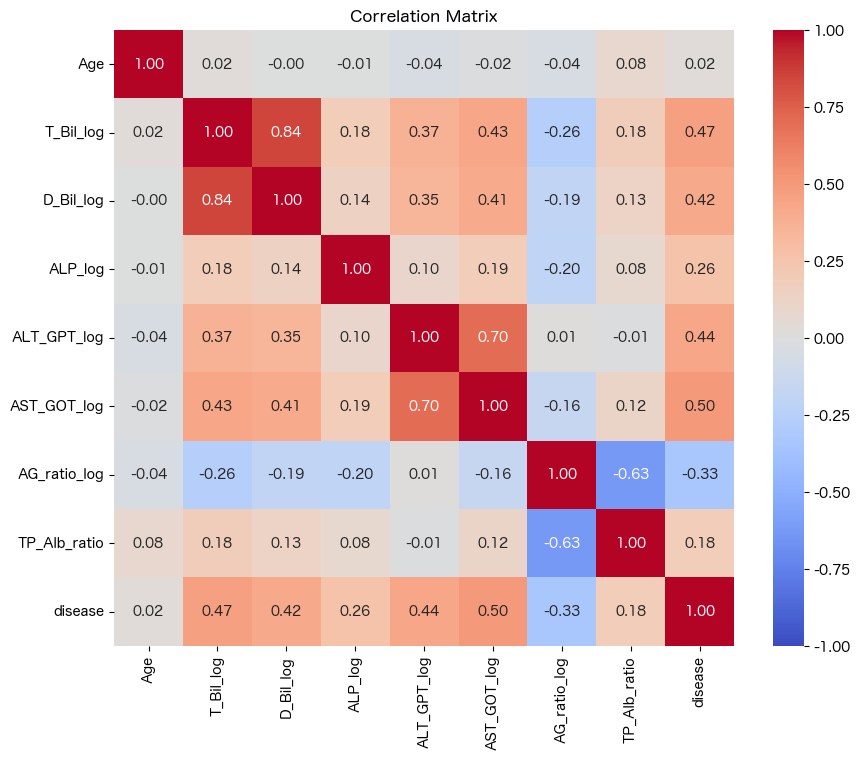

In [25]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 日本語フォントの設定
plt.rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro']  # Mac用
plt.rcParams['axes.unicode_minus'] = False

# データファイルを読み込み
data_path = '/Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/train/train_with_TP_Alb_ratio.csv'
train_data = pd.read_csv(data_path, low_memory=False)

# 数値変数のリスト
numeric_columns = [
    'Age', 'T_Bil_log', 'D_Bil_log', 'ALP_log', 'ALT_GPT_log', 'AST_GOT_log', 
    'AG_ratio_log', 'TP_Alb_ratio', 'disease'
]

# 数値変数間の相関行列を作成
corr_matrix = train_data[numeric_columns].corr().abs()

# 相関行列を上三角行列に変換して一意のペアを取得
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# 相関が高いペアを取得してソート
sorted_pairs = upper_triangle.unstack().sort_values(ascending=False).dropna()

# 上位15の相関ペアを表示
top_pairs = sorted_pairs.head(15)
print("Top Correlation Pairs:")
print(top_pairs)

# 相関が強い上位の特徴量をヒートマップで可視化
top_features = pd.Index(top_pairs.index.get_level_values(0).append(top_pairs.index.get_level_values(1))).unique()
top_corr_matrix = train_data[top_features].corr()
# 全ての数値変数の相関行列を表示
plt.figure(figsize=(10, 8))
sns.heatmap(train_data[numeric_columns].corr(), annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()


### 相関関係の高すぎる特徴量を削除する

In [26]:
import pandas as pd

# トレインデータの読み込み
data_path = '/Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/train/train_with_TP_Alb_ratio.csv'
train_data = pd.read_csv(data_path, low_memory=False)

# 目的変数 'disease' を最後の列に移動
# 'disease' 列を取得
disease_column = train_data['disease']

# '不要な列を削除して他の特徴量を残す
train_data = train_data.drop(columns=['disease', 'TP_log', 'Alb_log'])

# 'disease' 列を最後に追加
train_data['disease'] = disease_column

# 新しいデータセットの保存
save_path = '/Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/train/train_drop_TP_Alb.csv'
train_data.to_csv(save_path, index=False)

print(train_data.dtypes)
print(f"データが {save_path} に保存されました。")

Age               int64
Gender           object
T_Bil_log       float64
D_Bil_log       float64
ALP_log         float64
ALT_GPT_log     float64
AST_GOT_log     float64
AG_ratio_log    float64
TP_Alb_ratio    float64
disease           int64
dtype: object
データが /Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/train/train_drop_TP_Alb.csv に保存されました。


## ワンホットエンコーディングを適用する

In [27]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import joblib

# トレインデータの読み込み
data_path = '/Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/train/train_drop_TP_Alb.csv'
train_data = pd.read_csv(data_path)

# ワンホットエンコーディングを適用するカテゴリ変数
categorical_columns = ['Gender']

# OneHotEncoderのインスタンスを作成
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# カテゴリ変数をエンコード
encoded_columns = encoder.fit_transform(train_data[categorical_columns])

# エンコードされた列の名前を取得
encoded_col_names = encoder.get_feature_names_out(categorical_columns)

# エンコードされた列をデータフレームに変換
encoded_df = pd.DataFrame(encoded_columns, columns=encoded_col_names, index=train_data.index)

# オリジナルのデータフレームにエンコードされた列を追加
train_data = train_data.drop(categorical_columns, axis=1)
train_data = pd.concat([train_data, encoded_df], axis=1)

# 特徴量の確認
print(train_data.head())

# 新しい特徴量を含むデータを保存
output_path = '/Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/train/train_with_onehot_encoded_features.csv'
train_data.to_csv(output_path, index=False)
print(f"新しい特徴量を含むデータを保存しました: {output_path}")

# エンコーダーを保存
encoder_path = '/Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/train/onehot_encoder.pkl'
joblib.dump(encoder, encoder_path)
print(f"エンコーダーを保存しました: {encoder_path}")

   Age  T_Bil_log  D_Bil_log   ALP_log  ALT_GPT_log  AST_GOT_log  \
0   59   0.580474   0.140195  5.398971     2.671913     3.123652   
1   69   0.695139   0.178669  5.403661     3.951887     4.185895   
2   65   0.505093   0.078152  5.773839     2.611907     3.453574   
3   65   0.645438   0.194063  5.914255     3.565230     4.016565   
4   22   1.006116   0.180408  5.410672     3.071437     5.141723   

   AG_ratio_log  TP_Alb_ratio  disease  Gender_Female  Gender_Male  
0      0.006779      1.690427        0            0.0          1.0  
1     -0.285889      1.729961        1            0.0          1.0  
2     -0.254955      1.955172        0            0.0          1.0  
3     -0.011916      1.510940        1            0.0          1.0  
4      0.026305      1.573515        0            1.0          0.0  
新しい特徴量を含むデータを保存しました: /Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/train/train_with_onehot_encoded_features.csv
エンコーダーを保存しました: /Users/hayakawakazue/Downloads/sign

# 相関関係を再確認する

Top Correlation Pairs:
Gender_Male   Gender_Female    1.000000
D_Bil_log     T_Bil_log        0.844566
AST_GOT_log   ALT_GPT_log      0.695315
TP_Alb_ratio  AG_ratio_log     0.632703
disease       AST_GOT_log      0.499429
              T_Bil_log        0.468236
              ALT_GPT_log      0.435482
AST_GOT_log   T_Bil_log        0.432004
disease       D_Bil_log        0.417775
AST_GOT_log   D_Bil_log        0.408443
ALT_GPT_log   T_Bil_log        0.367679
              D_Bil_log        0.347391
disease       AG_ratio_log     0.330139
AG_ratio_log  T_Bil_log        0.262125
disease       ALP_log          0.260576
dtype: float64


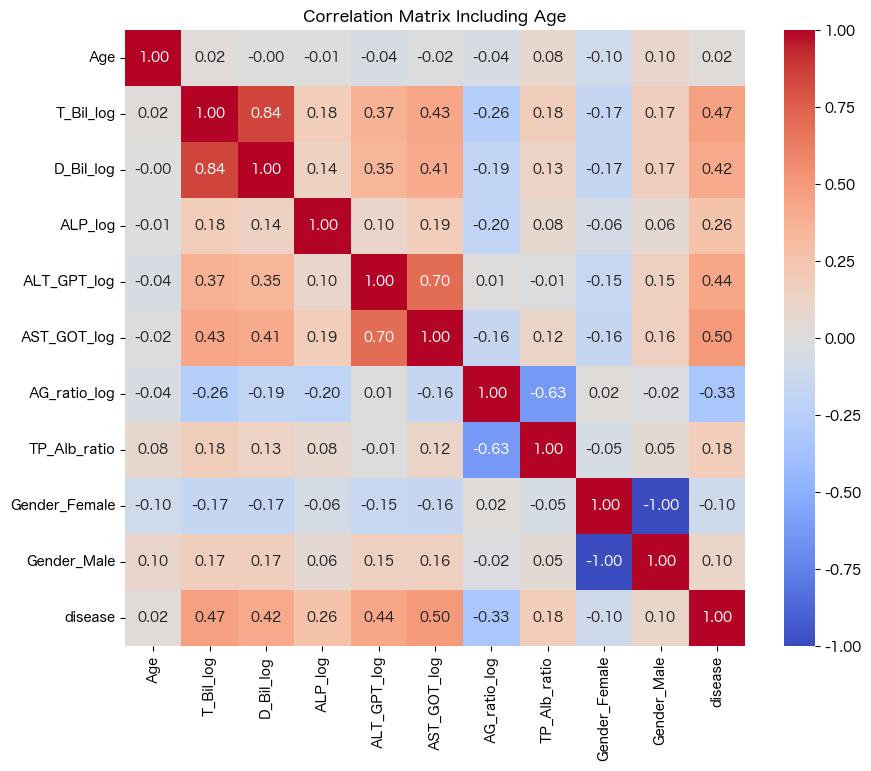

In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 日本語フォントの設定
plt.rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro']  # Mac用
plt.rcParams['axes.unicode_minus'] = False

# データファイルを読み込み
data_path = '/Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/train/train_with_onehot_encoded_features.csv'
train_data = pd.read_csv(data_path, low_memory=False)

# 数値変数のリスト
numeric_columns = [
    'Age', 'T_Bil_log', 'D_Bil_log', 'ALP_log', 'ALT_GPT_log', 'AST_GOT_log',
    'AG_ratio_log', 'TP_Alb_ratio', 'Gender_Female', 'Gender_Male', 'disease' 
]

# 数値変数間の相関行列を作成
corr_matrix = train_data[numeric_columns].corr().abs()

# 相関行列を上三角行列に変換して一意のペアを取得
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# 相関が高いペアを取得してソート
sorted_pairs = upper_triangle.unstack().sort_values(ascending=False).dropna()

# 上位15の相関ペアを表示
top_pairs = sorted_pairs.head(15)
print("Top Correlation Pairs:")
print(top_pairs)

# 相関が強い上位の特徴量をヒートマップで可視化
top_features = pd.Index(top_pairs.index.get_level_values(0).append(top_pairs.index.get_level_values(1))).unique()
top_corr_matrix = train_data[top_features].corr()
# 全ての数値変数の相関行列を表示
plt.figure(figsize=(10, 8))
sns.heatmap(train_data[numeric_columns].corr(), annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Matrix Including Age')
plt.show()

### 冗長な特徴量(Gender_Female)を削除する

In [28]:
import pandas as pd

# トレインデータの読み込み
data_path = '/Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/train/train_with_onehot_encoded_features.csv'
train_data = pd.read_csv(data_path, low_memory=False)

# 目的変数 'disease' を最後の列に移動
# 'disease' 列を取得
disease_column = train_data['disease']

# '不要な列を削除して他の特徴量を残す
train_data = train_data.drop(columns=['disease', 'Gender_Female'])

# 'disease' 列を最後に追加
train_data['disease'] = disease_column

# 新しいデータセットの保存
save_path = '/Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/train/train_drop_GenderFemale.csv'
train_data.to_csv(save_path, index=False)

print(train_data.dtypes)
print(f"データが {save_path} に保存されました。")

Age               int64
T_Bil_log       float64
D_Bil_log       float64
ALP_log         float64
ALT_GPT_log     float64
AST_GOT_log     float64
AG_ratio_log    float64
TP_Alb_ratio    float64
Gender_Male     float64
disease           int64
dtype: object
データが /Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/train/train_drop_GenderFemale.csv に保存されました。


## 相関関係を再確認する

Top Correlation Pairs:
D_Bil_log     T_Bil_log       0.844566
AST_GOT_log   ALT_GPT_log     0.695315
TP_Alb_ratio  AG_ratio_log    0.632703
disease       AST_GOT_log     0.499429
              T_Bil_log       0.468236
              ALT_GPT_log     0.435482
AST_GOT_log   T_Bil_log       0.432004
disease       D_Bil_log       0.417775
AST_GOT_log   D_Bil_log       0.408443
ALT_GPT_log   T_Bil_log       0.367679
              D_Bil_log       0.347391
disease       AG_ratio_log    0.330139
AG_ratio_log  T_Bil_log       0.262125
disease       ALP_log         0.260576
AG_ratio_log  ALP_log         0.198792
dtype: float64


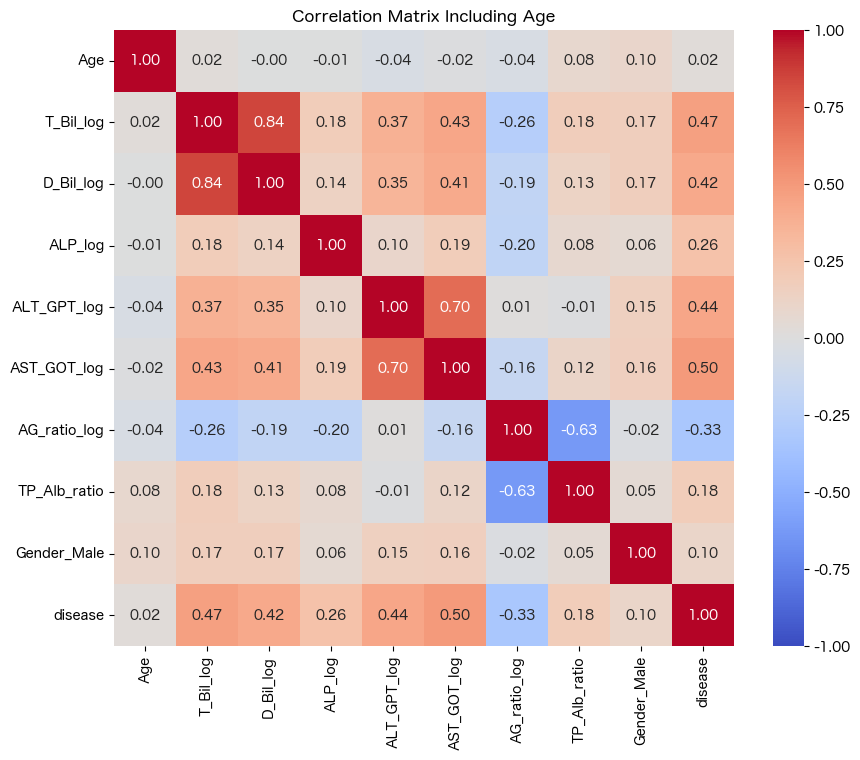

In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 日本語フォントの設定
plt.rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro']  # Mac用
plt.rcParams['axes.unicode_minus'] = False

# データファイルを読み込み
data_path = '/Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/train/train_drop_GenderFemale.csv'
train_data = pd.read_csv(data_path, low_memory=False)

# 数値変数のリスト
numeric_columns = [ 
    'Age', 'T_Bil_log', 'D_Bil_log', 'ALP_log', 'ALT_GPT_log',
    'AST_GOT_log','AG_ratio_log', 'TP_Alb_ratio', 
    'Gender_Male', 'disease'    
]

# 数値変数間の相関行列を作成
corr_matrix = train_data[numeric_columns].corr().abs()

# 相関行列を上三角行列に変換して一意のペアを取得
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# 相関が高いペアを取得してソート
sorted_pairs = upper_triangle.unstack().sort_values(ascending=False).dropna()

# 上位15の相関ペアを表示
top_pairs = sorted_pairs.head(15)
print("Top Correlation Pairs:")
print(top_pairs)

# 相関が強い上位の特徴量をヒートマップで可視化
top_features = pd.Index(top_pairs.index.get_level_values(0).append(top_pairs.index.get_level_values(1))).unique()
top_corr_matrix = train_data[top_features].corr()
# 全ての数値変数の相関行列を表示
plt.figure(figsize=(10, 8))
sns.heatmap(train_data[numeric_columns].corr(), annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Matrix Including Age')
plt.show()

# RobustScalerでスケーリングする
ロバストに適用しているので、試してみました。

In [15]:
import pandas as pd
from sklearn.preprocessing import RobustScaler
import joblib

# トレインデータの読み込み
data_path = '/Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/train/train_drop_GenderFemale.csv'
train_data = pd.read_csv(data_path, low_memory=False)

# disease列をスケーリングから除外
y_train = train_data['disease']
X_train = train_data.drop(columns=['disease'])

# スケーリングを行うカラムを指定
columns_to_scale = [ 
    'Age', 'T_Bil_log', 'D_Bil_log', 'ALP_log', 'ALT_GPT_log', 'AST_GOT_log',
    'AG_ratio_log', 'TP_Alb_ratio'
]

# スケーリング対象の列が存在するか確認
missing_columns = [col for col in columns_to_scale if col not in X_train.columns]
if missing_columns:
    print(f"以下のカラムがデータに存在しません: {missing_columns}")
else:
    # RobustScalerのインスタンスを作成してスケーリング
    scaler = RobustScaler()
    X_train[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])

    # スケーリング後にdisease列を再度結合
    train_scaled = pd.concat([X_train, y_train], axis=1)

    # データの保存
    output_path = '/Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/train/train_scaled_robust_0919_1.csv'
    train_scaled.to_csv(output_path, index=False)
    print(f"disease列を保持したままスケーリング済みのデータを保存しました: {output_path}")

    # スケーラーの保存
    scaler_path = '/Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/train/train_robust_scaler.pkl'
    joblib.dump(scaler, scaler_path)
    print(f"スケーラーを保存しました: {scaler_path}")


disease列を保持したままスケーリング済みのデータを保存しました: /Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/train/train_scaled_robust_0919_1.csv
スケーラーを保存しました: /Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/train/train_robust_scaler.pkl


### PCAを適用する
PCAを適用してモデルのトレーニングもしましたが、高い

In [2]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import joblib

# すでにスケーリングされたデータを読み込み（例: CSVファイルから）
# トレインデータの読み込み
data_path = '/Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/train/train_scaled_robust_0915_1.csv'
train_data = pd.read_csv(data_path, low_memory=False)

# 特徴量を選択
selected_features = [
    'T_Bil_log', 'AST_GOT_log', 'ALT_GPT_log', 'AG_ratio_log', 'D_Bil_log', 
    'ALP_log', 'TP_log', 'Alb_log', 'Age', 'Gender_Male'
]

# disease列をスケーリングから除外（ターゲット変数を分離）
y_train = train_data['disease']
X_train = train_data[selected_features]  # selected_features のみを使用

# PCAの適用
pca = PCA(n_components=3)  # 主成分の数を指定
X_pca = pca.fit_transform(X_train)

# 主成分の数をプリント
print(f"累積分散比: {np.cumsum(pca.explained_variance_ratio_)}")

# PCA適用後のデータフレームにターゲット（disease）を再結合
X_pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
train_pca_final = pd.concat([X_pca_df, y_train.reset_index(drop=True)], axis=1)

# PCA後のデータを保存 (データの保存先を指定)
pca_data_path = '/Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/train/train_pca_transformed_data.csv'
train_pca_final.to_csv(pca_data_path, index=False)

print(f"PCA適用後のデータを保存しました: {pca_data_path}")

# PCAモデルの保存
pca_path = '/Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/model/pca_model.joblib'
joblib.dump(pca, pca_path)
print(f"PCAモデルを保存しました: {pca_path}")



累積分散比: [0.59131607 0.85282445 0.90188557]
PCA適用後のデータを保存しました: /Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/train/train_pca_transformed_data.csv
PCAモデルを保存しました: /Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/model/pca_model.joblib


## StandardScalerでスケーリングする

In [29]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import joblib

# トレインデータの読み込み
data_path = '/Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/train/train_drop_GenderFemale.csv'
train_data = pd.read_csv(data_path, low_memory=False)

# disease列をスケーリングから除外
y_train = train_data['disease']
X_train = train_data.drop(columns=['disease'])

# スケーリングを行うカラムを指定
columns_to_scale = [ 
    'Age', 'T_Bil_log', 'D_Bil_log', 'ALP_log', 'ALT_GPT_log', 'AST_GOT_log',
    'AG_ratio_log', 'TP_Alb_ratio'
]
 
# スケーリング対象の列が存在するか確認
missing_columns = [col for col in columns_to_scale if col not in X_train.columns]
if missing_columns:
    print(f"以下のカラムがデータに存在しません: {missing_columns}")
else:
    # 無限大の値や非常に大きな値の処理を各カラムで個別に行う
    for col in columns_to_scale:
        X_train[col] = X_train[col].replace([np.inf, -np.inf], np.nan)

# NaN値を平均で補完
    for col in columns_to_scale:
        X_train[col] = X_train[col].fillna(X_train[col].mean())

    # StandardScalerのインスタンスを作成してスケーリング
    scaler = StandardScaler()
    X_train[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])

    # スケーリング後にdisease列を再度結合
    train_scaled = pd.concat([X_train, y_train], axis=1)

    # データの保存
    output_path = '/Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/train/train_std_scaled_0919_1.csv'
    train_scaled.to_csv(output_path, index=False)
    print(f"disease列を保持したままスケーリング済みのデータを保存しました: {output_path}")

# スケーラーの保存
    scaler_path = '/Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/train/train_std_scaler.pkl'
    joblib.dump(scaler, scaler_path)
    print(f"スケーラーを保存しました: {scaler_path}")

disease列を保持したままスケーリング済みのデータを保存しました: /Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/train/train_std_scaled_0919_1.csv
スケーラーを保存しました: /Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/train/train_std_scaler.pkl
